In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 0. import data

In [2]:
# set random state
np.random.seed(42)

In [3]:
# load data
train = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/train_ready.csv')
test = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/test_ready.csv')

In [4]:
# drop price_per_m2 from train
train = train.drop(columns=['price_per_m2'])

In [5]:
# Custom dataset class
class PropertyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [6]:
# Neural Network model
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.view(-1, 1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val.view(-1, 1)).item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [ ]:
# prep data
def prepare_data(train_df):
    # Select numeric columns and target
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    feature_cols = [col for col in numeric_cols if col not in ['price', 'property_id']]
    
    # Split features and target
    X = train_df[feature_cols].values
    y = train_df['price'].values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Scale target (log transform for price)
    y_log = np.log1p(y)
    
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_log, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = PropertyDataset(X_train, y_train)
    val_dataset = PropertyDataset(X_val, y_val)
    
    return train_dataset, val_dataset, scaler, feature_cols

Using device: cpu
Epoch [5/50], Train Loss: 0.2002, Val Loss: 0.1730
Epoch [10/50], Train Loss: 0.1689, Val Loss: 0.1387
Epoch [15/50], Train Loss: 0.1594, Val Loss: 0.1387
Epoch [20/50], Train Loss: 0.1506, Val Loss: 0.1297
Epoch [25/50], Train Loss: 0.1469, Val Loss: 0.1267
Epoch [30/50], Train Loss: 0.1450, Val Loss: 0.1661
Epoch [35/50], Train Loss: 0.1415, Val Loss: 0.1318
Epoch [40/50], Train Loss: 0.1374, Val Loss: 0.1320
Epoch [45/50], Train Loss: 0.1375, Val Loss: 0.1218
Epoch [50/50], Train Loss: 0.1368, Val Loss: 0.1292


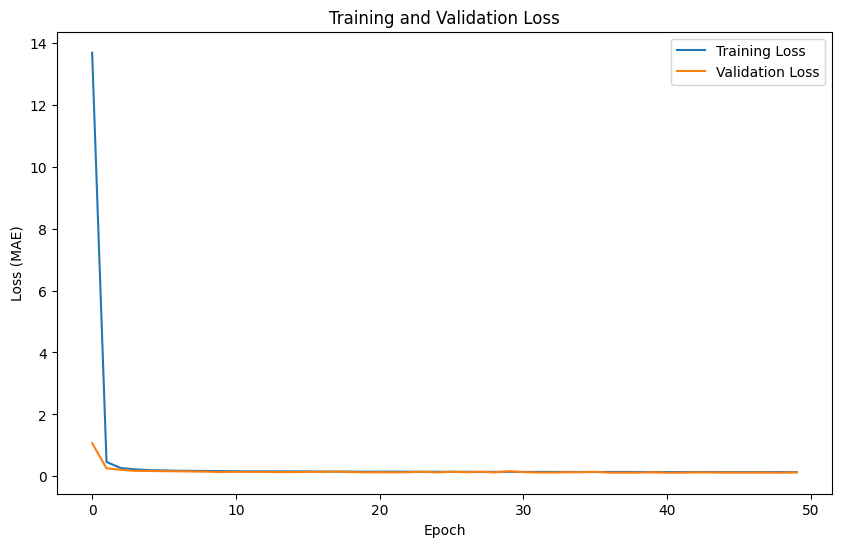

In [ ]:
# main training setup
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, device, num_epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

# Usage
model, scaler, feature_cols = setup_and_train(train)

In [14]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  673600576
1  45550aa81c0151f1fd9fd8fe  676189248
2  735deef3382aa15930482f3e  688502144
3  0dd49fa8bb7be52b851c6dc9  692305152
4  7d3220a91e78f8bc2924d1cd  675153088
